In [ ]:

import pandas as pd
import numpy as np
from unidecode import unidecode
from libpysal.weights.contiguity import Queen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#df_f0=pd.read_excel("Bases//Base_Limpia.xlsx")

from scipy.stats import pearsonr, chi2_contingency

df_f0=pd.read_csv("Bases//Base_Limpia_Added.csv")

df_f=df_f0.copy()


In [15]:
df_f0.columns

Index(['id', 'fnyear', 'sexo', 'edad', 'provincia', 'id_provincia',
       'departamento', 'id_departamento', 'localidad', 'fecha',
       'prueba_resistencia', 'resistencia', 'droga', 'tipo_resistencia',
       'prueba_vih', 'resultado_hiv', 'embarazo', 'embarazo_y_o_puerperio',
       'diabetes', 'consumo_prob_drogas', 'enf_resp_cronica', 'covid', 'etnia',
       'tabaquismo', 'alcoholismo', 'estab_tto', 'inicio_trat',
       'fecha_fin_trat', 'resultado_tratamiento', 'link', 'salud',
       'poblacion_estimada', 'densidad_estimada', 'cod_prov', 'index obesity',
       'Nivel de incidencia de pobreza crónica',
       '% de hogares con hacinamiento crítico',
       '% de hogares en vivienda deficitaria',
       '% de hogares sin acceso a red cloacal',
       '% de población en situación de pobreza crónica',
       '% de población sin obra social ni prepaga', 'DD', 'FF', 'PNM', 'TEMP',
       'HUM', 'dia_semana', '1_o_15', 'Dia_Festivo', 'es_dia_laboral'],
      dtype='object')

In [17]:
import pandas as pd

# --- config ---
POP_COL = 'poblacion_estimada'   # cambia si el nombre difiere
REGION_CANDIDATES = ['region', 'provincia', 'departamento']
START, END = '2009-01-01', '2022-12-31'

df = df_f.copy()
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha'])
df = df[(df['fecha'] >= START) & (df['fecha'] <= END)].copy()
df['year'] = df['fecha'].dt.year

# detectar columna de región (si existe)
region_col = next((c for c in REGION_CANDIDATES if c in df.columns), None)

# --- [N] total de notificaciones ---
N = int(len(df))

# --- mediana semanal e IQR [x], [a–b] ---
weekly = df.set_index('fecha').groupby(pd.Grouper(freq='W')).size()
x = float(weekly.median().round(2))
q25, q75 = weekly.quantile([0.25, 0.75]).round(2).tolist()

# --- incidencia anual por 100k: [r], [min–max] ---
annual_cases = df.groupby('year').size()

if region_col is not None:
    # sumar la media anual por región para evitar duplicados
    annual_pop = (df.groupby(['year', region_col])[POP_COL].mean()
                    .groupby('year').sum()
                    .reindex(annual_cases.index))
else:
    # sin región: usar media anual del total
    annual_pop = (df.groupby('year')[POP_COL].mean()
                    .reindex(annual_cases.index))

annual_inc = (annual_cases / annual_pop * 1e5)
r     = float(annual_inc.mean().round(2))
r_min = float(annual_inc.min().round(2))
r_max = float(annual_inc.max().round(2))

# --- regiones con mayores tasas [regions] ---
if region_col is not None:
    # usar población del último año disponible en [2010..2022] si existe, si no promedio
    prefer_years = [y for y in range(2022, 2009, -1) if y in df['year'].unique()]
    if prefer_years:
        yr = prefer_years[0]
        pop_reg = (df.loc[df['year'] == yr]
                     .groupby(region_col)[POP_COL].mean())
    else:
        pop_reg = df.groupby(region_col)[POP_COL].mean()

    cases_by_region = df.groupby(region_col).size()
    common = cases_by_region.index.intersection(pop_reg.index)
    inc_by_region = (cases_by_region[common] / pop_reg[common] * 1e5).sort_values(ascending=False)
    top_regions = ', '.join(inc_by_region.head(3).index)
else:
    top_regions = '—'

# --- frase final ---
sentence = (
    f"Descriptive epidemiology. Between 2010–2022, we observed {N} TB notifications "
    f"(median {x:.2f} per week, IQR {q25:.2f}–{q75:.2f}). The overall annual incidence was "
    f"{r:.2f} per 100,000 (range {r_min:.2f}–{r_max:.2f} across years), with higher rates in "
    f"{top_regions}. Summary statistics are shown in Table 3."
)
print(sentence)

# --- (opcional) construir Table 3 ---
table3 = (annual_cases.to_frame('Total cases')
          .assign(Population=annual_pop,
                  Incidence_per_100k=annual_inc.round(2)))
table3.index.name = 'Year'
table3 = table3.reset_index()


Descriptive epidemiology. Between 2010–2022, we observed 149550 TB notifications (median 204.00 per week, IQR 165.50–243.00). The overall annual incidence was 25.07 per 100,000 (range 21.77–28.71 across years), with higher rates in Salta, Jujuy, CABA. Summary statistics are shown in Table 3.


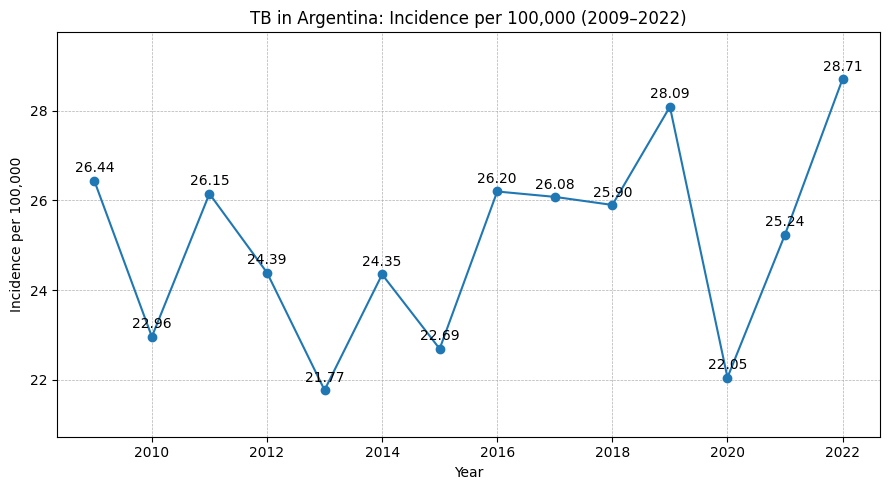

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Expect: table3 has columns 'Year' and either 'Incidence per 100,000' or 'Incidence_per_100k'
t3 = table3.rename(columns={'Incidence_per_100k': 'Incidence per 100,000'}).copy()
t3 = t3[['Year', 'Incidence per 100,000']].sort_values('Year')

years = t3['Year'].to_list()
inc   = t3['Incidence per 100,000'].to_list()

fig, ax = plt.subplots(figsize=(9,5))

# line + markers
ax.plot(years, inc, marker='o')
ax.set_xlabel('Year')
ax.margins(y=0.15)
ax.set_ylabel('Incidence per 100,000')
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
ax.set_title('TB in Argentina: Incidence per 100,000 (2009–2022)')

# annotate each point with its incidence value (2 decimals)
for x, y in zip(years, inc):
    ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,6), ha='center')

plt.tight_layout()
plt.savefig('Documentacion/figures/tb_incidence_line.png', dpi=300, bbox_inches='tight')
plt.show()


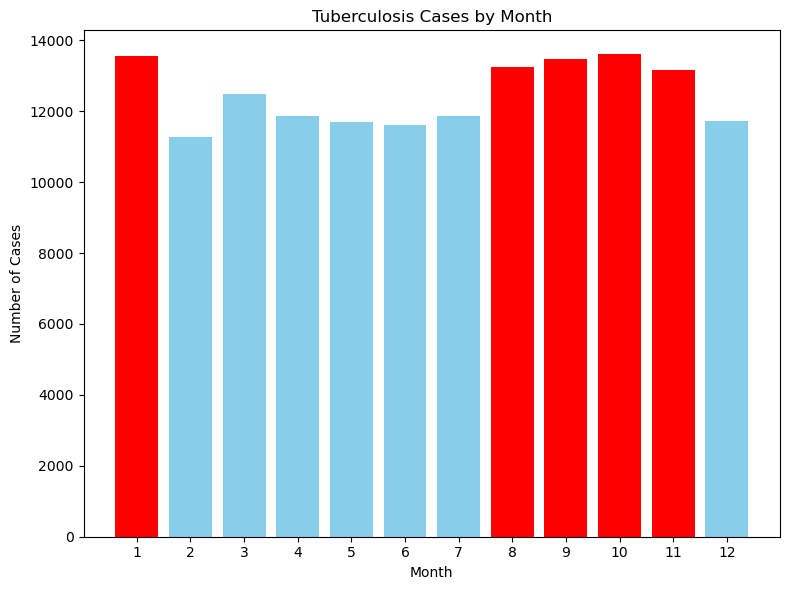

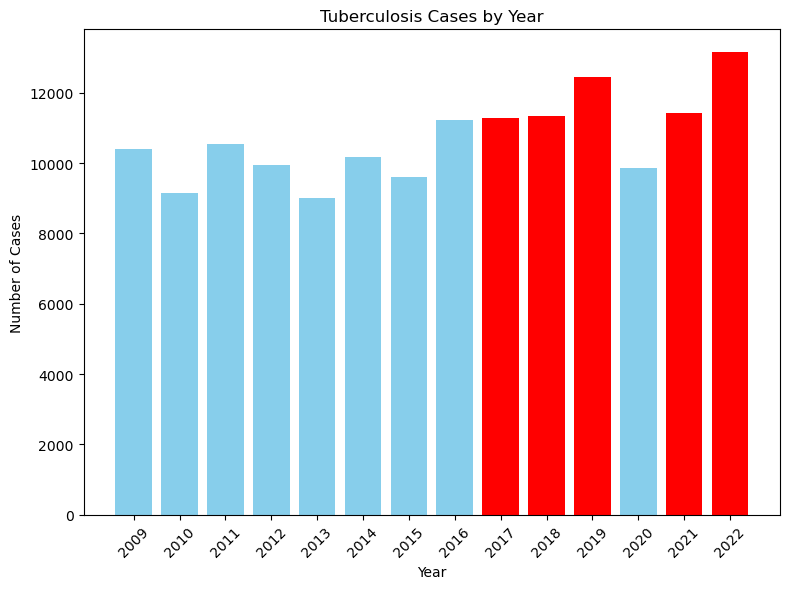

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_f0 is your DataFrame and the following preprocessing has been done:
df_f0['fecha'] = pd.to_datetime(df_f0['fecha'])
df_f0['fnyear'] = df_f0['fecha'].dt.year
df_f0['fnmonth'] = df_f0['fecha'].dt.month

# Filter out the years 2009 and 2022
df_filtered = df_f0[(df_f0['fnyear'] != 2006) & (df_f0['fnyear'] != 2023)]

# Group by year and count cases
cases_by_year = df_filtered.groupby('fnyear').size()

# Get the top 5 years with the highest number of cases
top_5_years = cases_by_year.nlargest(5)

# Group by month and count cases
cases_by_month = df_filtered.groupby('fnmonth').size()

# Get the top 5 months with the highest number of cases
top_5_months = cases_by_month.nlargest(5)

# Plotting tuberculosis cases by month
plt.figure(figsize=(8, 6))
colors_month = ['red' if month in top_5_months.index else 'skyblue' for month in cases_by_month.index]
plt.bar(cases_by_month.index, cases_by_month.values, color=colors_month)
plt.title('Tuberculosis Cases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cases')
plt.xticks(cases_by_month.index)
plt.tight_layout()
plt.savefig('Documentacion\\figures\\cases_by_month.png', dpi=300)  # Save the plot as PNG
plt.show()

# Plotting tuberculosis cases by year
plt.figure(figsize=(8, 6))
colors_year = ['red' if year in top_5_years.index else 'skyblue' for year in cases_by_year.index]
plt.bar(cases_by_year.index, cases_by_year.values, color=colors_year)
plt.title('Tuberculosis Cases by Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.xticks(cases_by_year.index, rotation=45)
plt.tight_layout()
plt.savefig('Documentacion\\figures\\cases_by_year.png', dpi=300)  # Save the plot as PNG
plt.show()



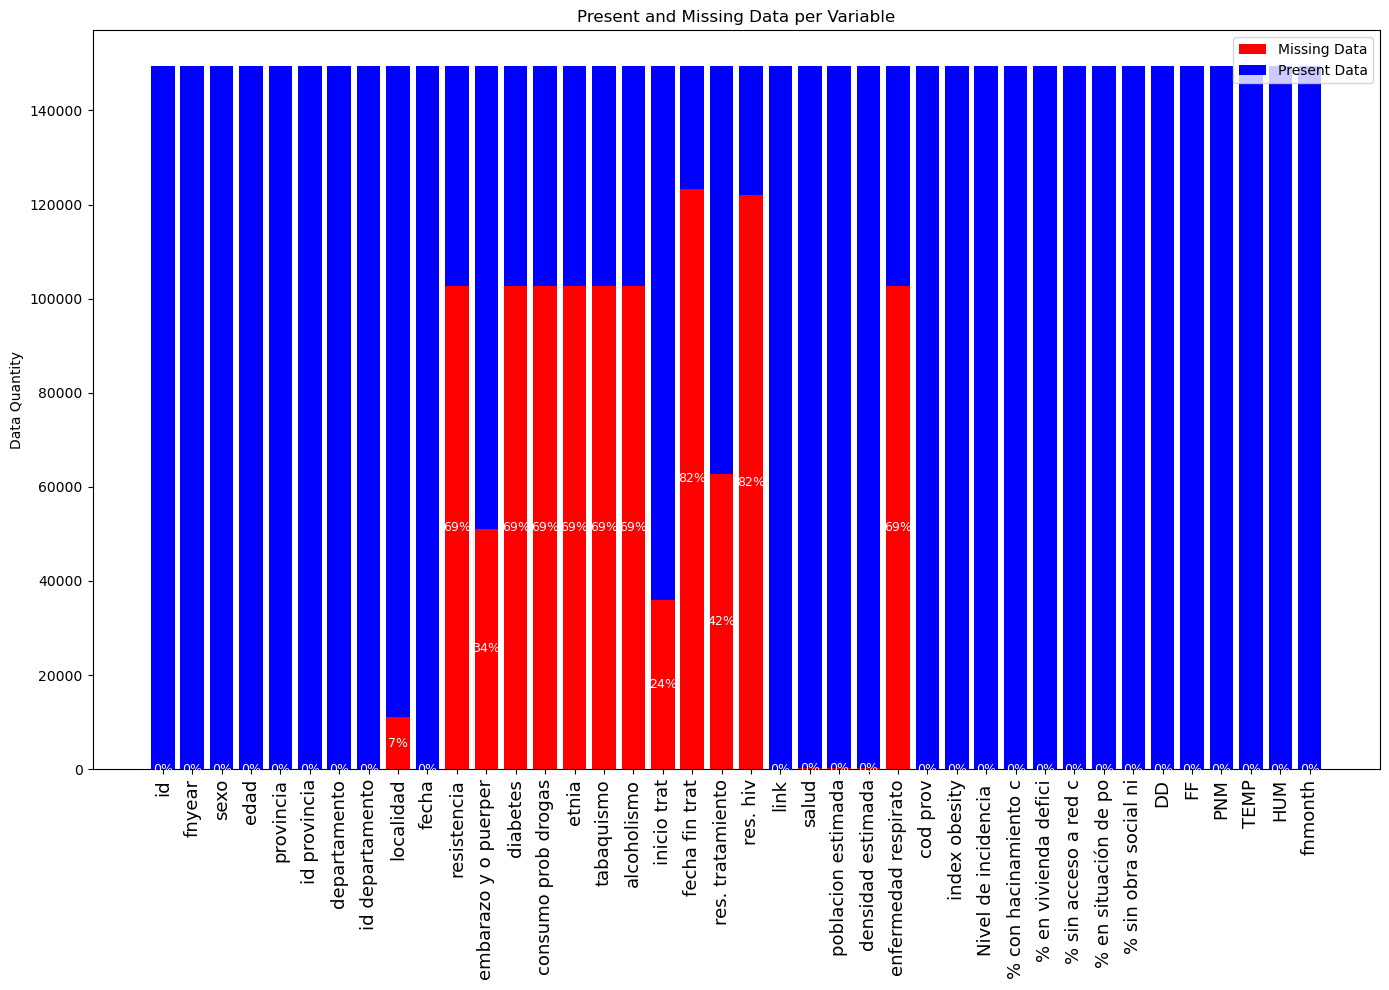

In [3]:



df_f_0_f = df_f0.copy()
df_f_0_f.replace('Sin Información', np.nan, inplace=True)

l_columns=df_f_0_f.columns
l_predictos2=[]
for s in l_columns:
    

    l_predictos2.append(s.replace("_"," ").replace(" crónica","").replace(" de hogares","").replace(" de población","").replace("resultado","res.")[:20])




df_f_0_f.columns=l_predictos2
# Create DataFrame for missing data
df_missing = pd.DataFrame(df_f_0_f.isnull().sum(), columns=["Missing Data #"])
df_missing["% Missing"] = round(df_missing["Missing Data #"] / len(df_f_0_f) * 100, 2)

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust chart size

# Get variables and values
variables = df_missing.index
values = df_missing["Missing Data #"]
percentages = df_missing["% Missing"]

# Blue bars for present data
blue_bar = ax.bar(variables, values, color='red', label='Missing Data')

# Red bars for missing data
red_bar = ax.bar(variables, len(df_f_0_f) - values, bottom=values, color='blue', label='Present Data')

# Percentage labels for missing data
for i, (percentage, value) in enumerate(zip(percentages, values)):
    ax.text(i, value / 2, f"{percentage:.0f}%", ha='center', va='center', color='white', fontsize=9)  # Change color to white

# Chart configuration
ax.set_ylabel('Data Quantity')
ax.set_title('Present and Missing Data per Variable')
ax.legend()

# Display chart
plt.xticks(rotation=90, fontsize=13)  # Ajusta el tamaño aquí

plt.tight_layout()
plt.savefig('Documentacion\\figures\\missing_data_chart.png', dpi=300)  # Higher resolution
plt.show()



In [4]:
# Calculate the minimum date in the dataset
min_fecha = pd.to_datetime(df_f['fecha']).min()

# Calculate the week number for each record
df_f['NUMERO_SEMANA'] = ((pd.to_datetime(df_f['fecha']) - min_fecha).dt.days // 7) + 1

# Create a pivot table to count the number of cases per week per province
df_aux2 = df_f.copy()
df_aux2 = pd.pivot_table(df_aux2, index=["provincia", "NUMERO_SEMANA"], values=["fecha"], aggfunc="count")

# Convert the pivot table to a DataFrame
df_aux3 = pd.DataFrame(df_aux2.to_records())
df_aux3.columns = ["provincia", "NUMERO_SEMANA", "CANTIDAD_CASOS"]

# Filter out rows where the province is "Desconocida"
df_aux3 = df_aux3.loc[df_aux3["provincia"] != "Desconocida"]

# Merge with the estimated population data and drop duplicates
df_aux2 = pd.merge(df_aux3, df_f[["provincia", "poblacion_estimada"]].drop_duplicates(), on="provincia", how="left").drop_duplicates(subset=["provincia", "NUMERO_SEMANA"], keep="first")

# Calculate the number of cases per inhabitant
df_aux2["N_CASOS_HAB"] = df_aux2["CANTIDAD_CASOS"] / df_aux2["poblacion_estimada"]

# Calculate the smoothed number of cases per inhabitant using a rolling mean
df_aux2["N_CASOS_HAB_SUAV"] = df_aux2.groupby('provincia')["N_CASOS_HAB"].rolling(window=52, min_periods=1).mean().reset_index(0, drop=True)


In [5]:
df_aux2.loc[df_aux2["provincia"]=="Santa Cruz","CANTIDAD_CASOS"].mean()

1.871345029239766

In [24]:
df_aux2['date'] = min_fecha + pd.to_timedelta((df_aux2['NUMERO_SEMANA'] - 1)*7, unit='d')
df_aux2

,provincia,NUMERO_SEMANA,CANTIDAD_CASOS,poblacion_estimada,N_CASOS_HAB,N_CASOS_HAB_SUAV,date
0,Buenos Aires,1,132,1.545278e+07,8.542151e-06,0.000009,2009-01-01
4892,Buenos Aires,2,54,1.545278e+07,3.494516e-06,0.000006,2009-01-08
9784,Buenos Aires,3,194,1.545278e+07,1.255437e-05,0.000008,2009-01-15
14676,Buenos Aires,4,47,1.545278e+07,3.041523e-06,0.000007,2009-01-22
19568,Buenos Aires,5,123,1.545278e+07,7.959731e-06,0.000007,2009-01-29
...,...,...,...,...,...,...,...
26176910,Tucuman,726,1,1.418488e+06,7.049762e-07,0.000003,2022-11-24
26178913,Tucuman,727,9,1.418488e+06,6.344786e-06,0.000003,2022-12-01
26180916,Tucuman,728,1,1.418488e+06,7.049762e-07,0.000003,2022-12-08
26182919,Tucuman,729,4,1.418488e+06,2.819905e-06,0.000003,2022-12-15


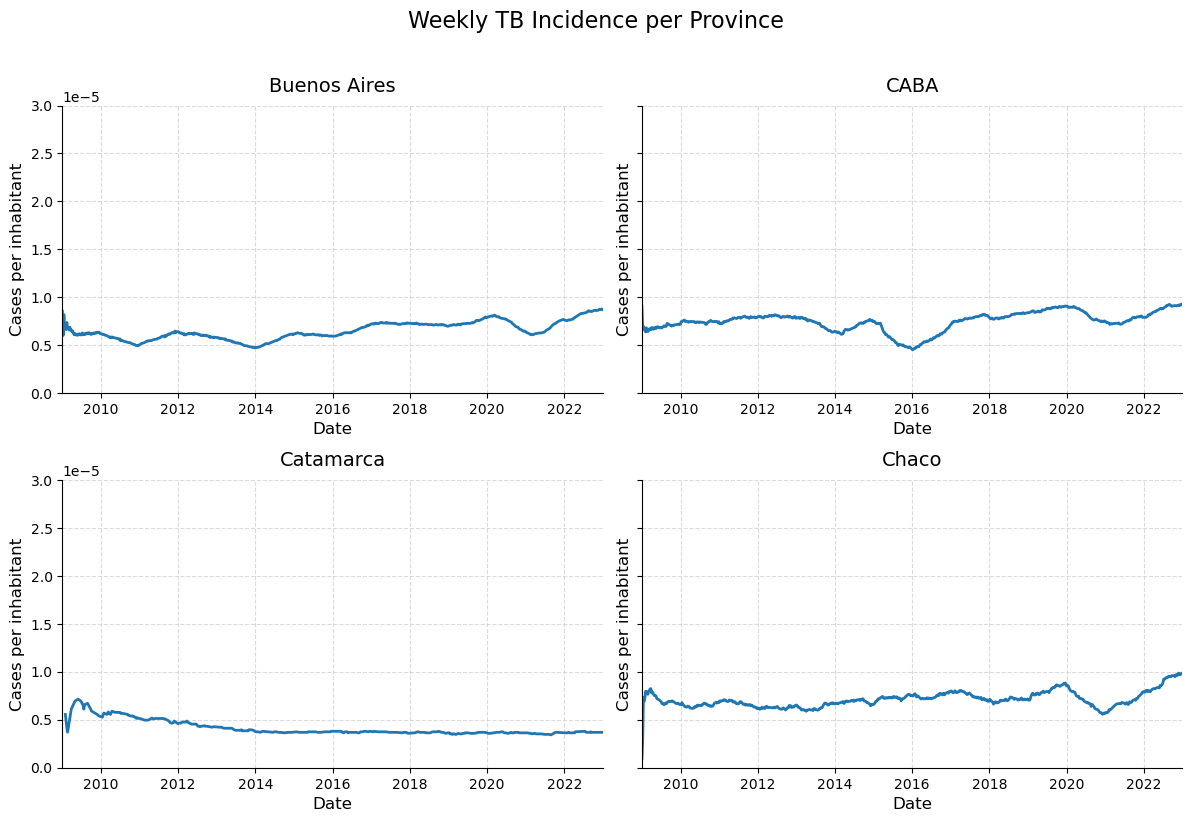

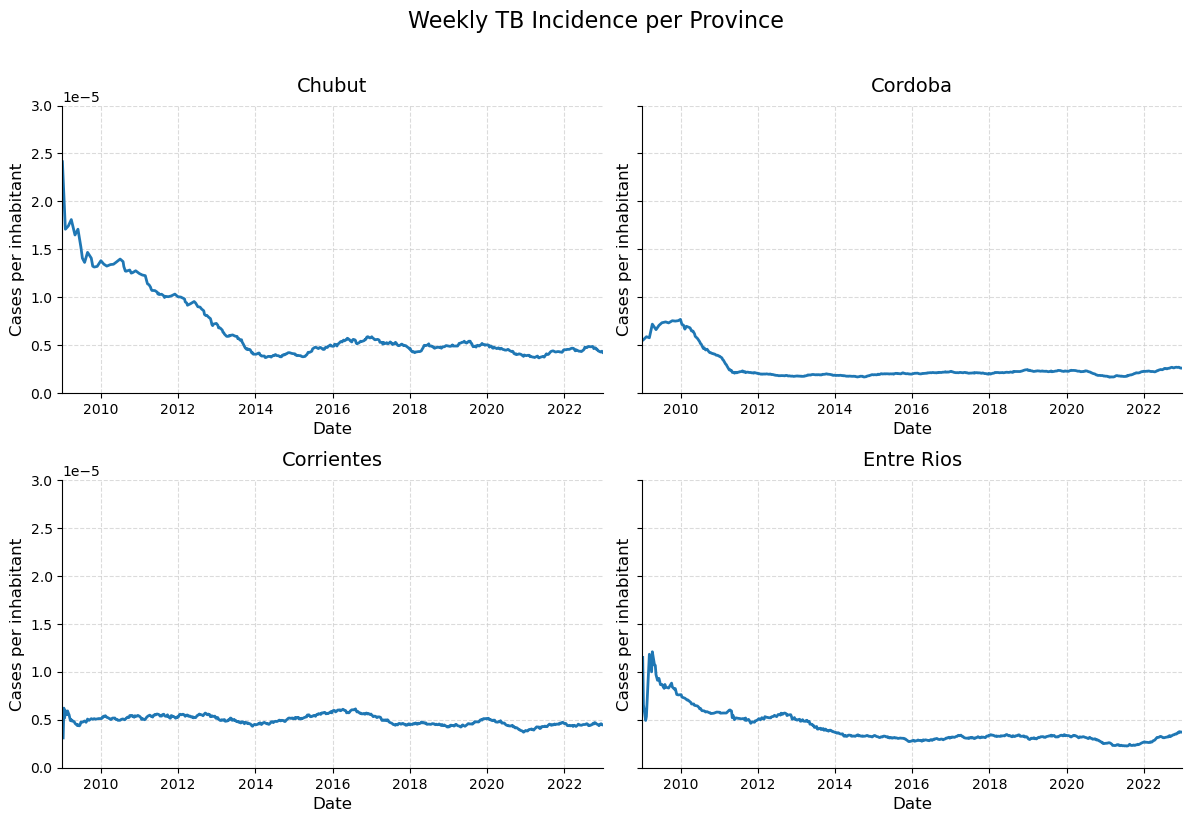

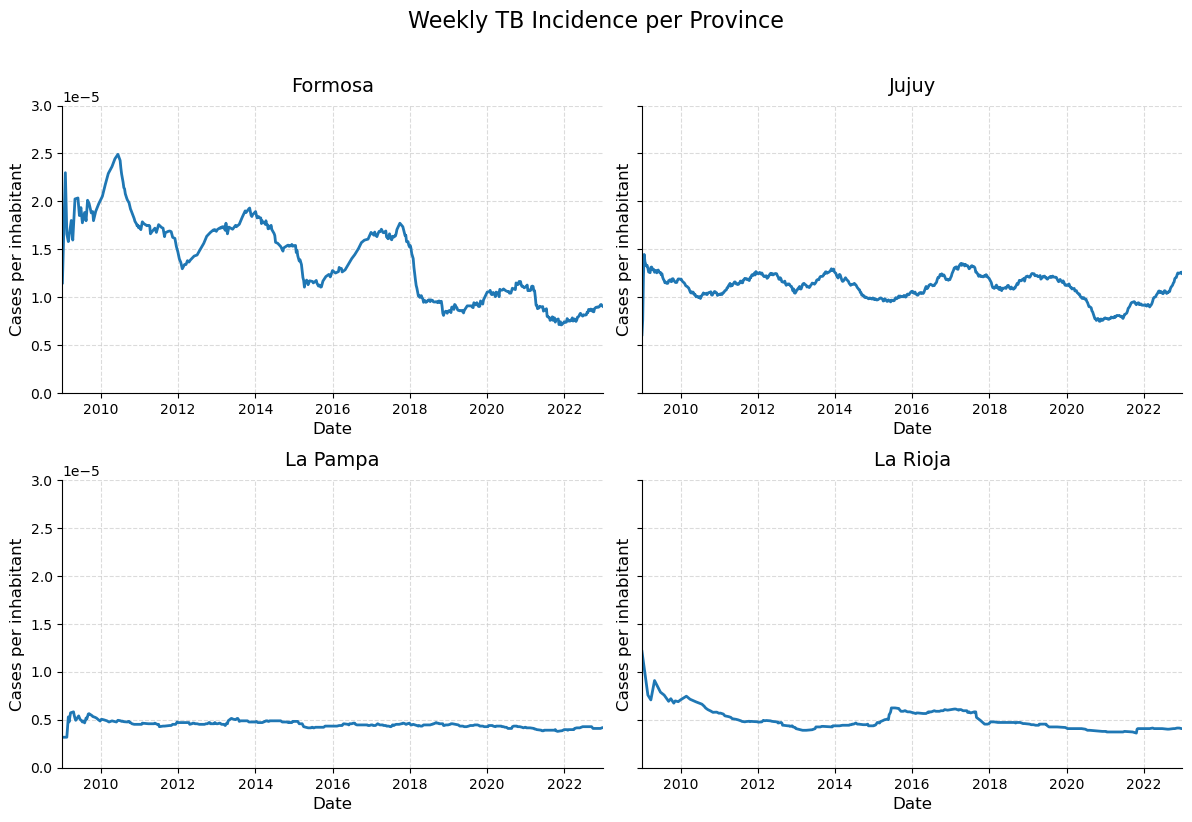

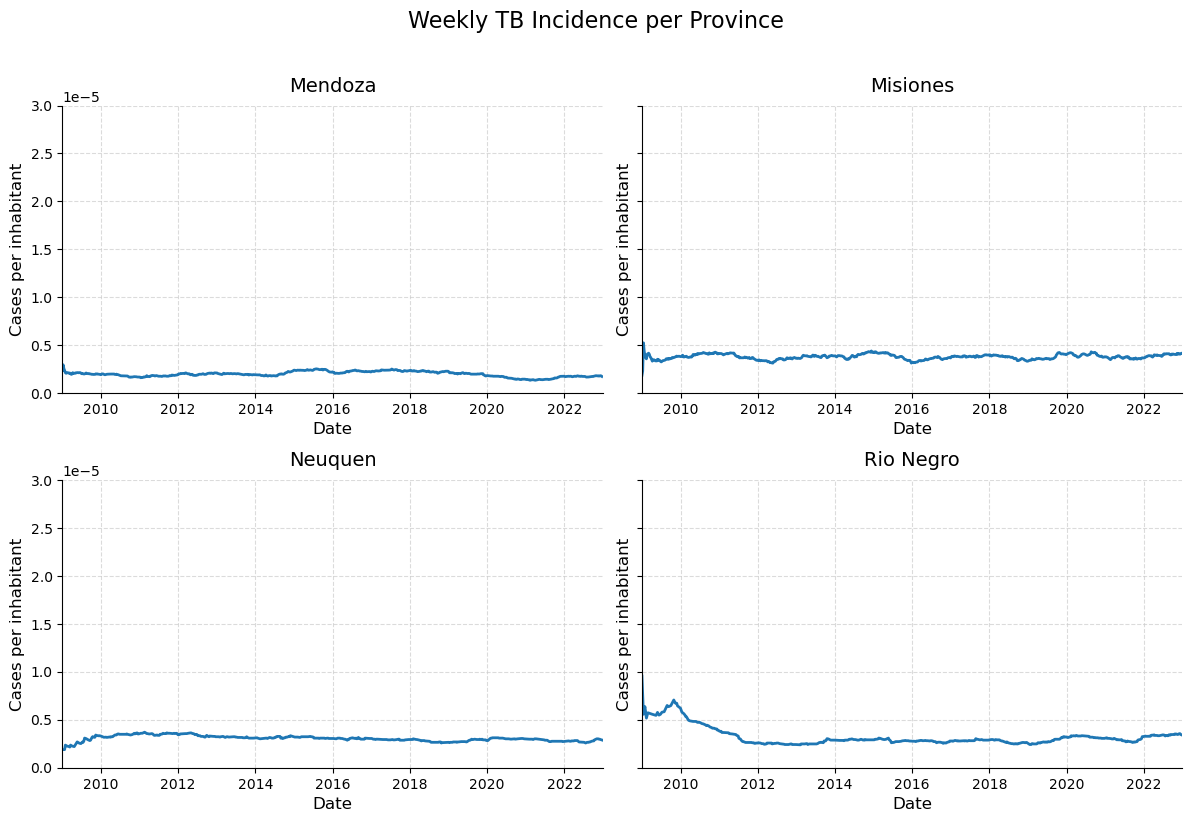

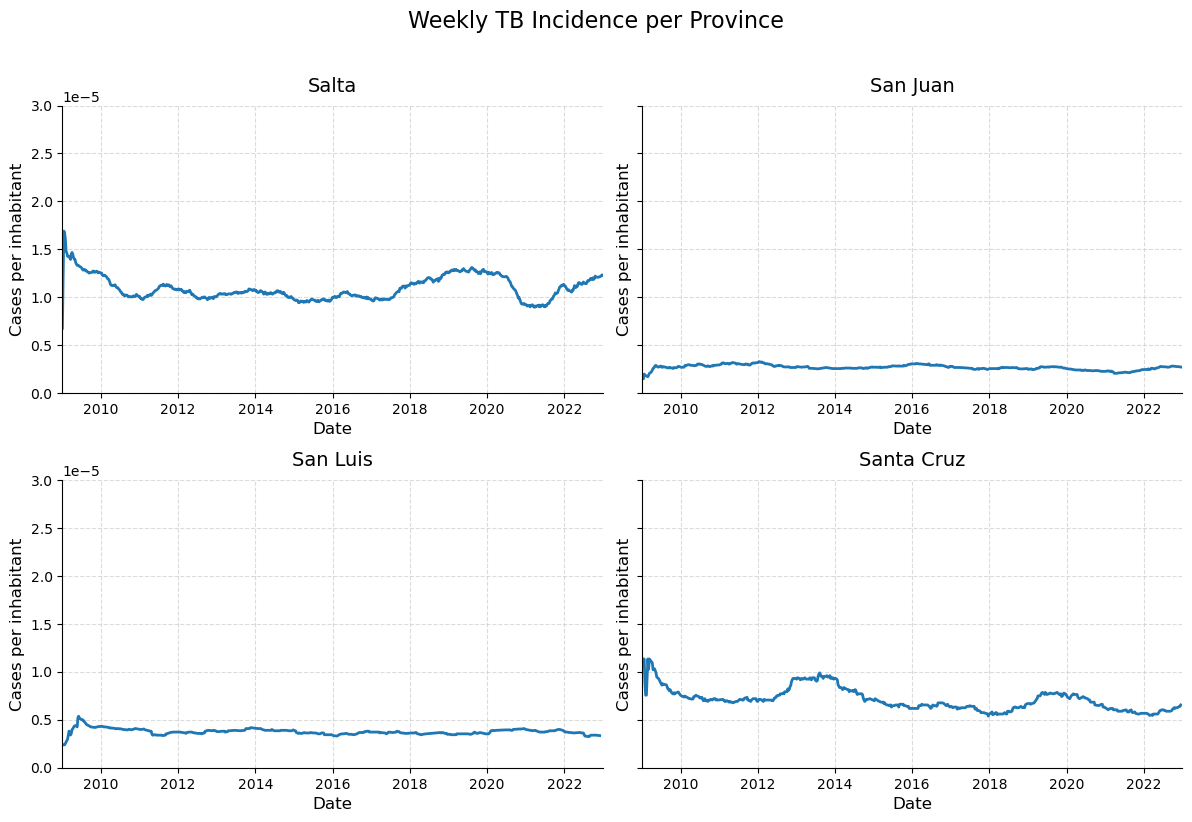

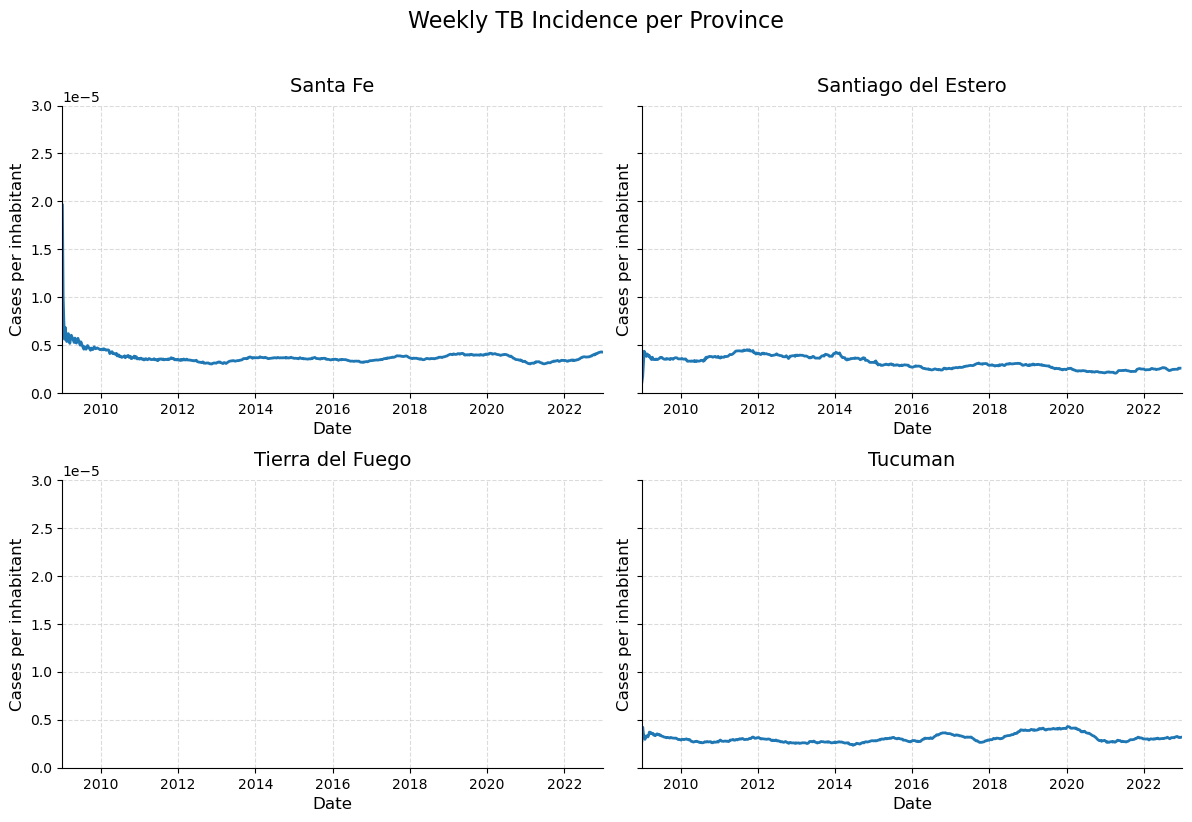

In [30]:
def plotear_provincia(df_aux2,i,save=False):
    """
    Plots the smoothed number of cases per inhabitant for each province over time.

    Args:
    df_aux2 (pd.DataFrame): DataFrame containing the data to be plotted.
    """
    plt.figure(figsize=(10, 6))

    provincias = df_aux2['provincia'].unique()
    for provincia in provincias:
        provincia_df = df_aux2[df_aux2['provincia'] == provincia]
        plt.plot(provincia_df['NUMERO_SEMANA'], provincia_df["N_CASOS_HAB_SUAV"], label=provincia)

    plt.xlabel('Week Number')
    plt.ylabel('Incidence by week')
    plt.title('Incidence by week for each province')
    plt.legend()
    plt.grid(True)
    if save==True:
        plt.savefig(f'Documentacion\\figures\\top_provinces{i}.png', dpi=300)  # Higher resolution
    plt.show()

def plotear_provincia(df, i, save=False):
    provincias = df['provincia'].unique()
    n = len(provincias)
    cols = 2
    rows = (n + 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharey=True)
    axes = axes.flatten()

    for ax, prov in zip(axes, provincias):
        d = df[df['provincia']==prov]
        ax.plot(d['NUMERO_SEMANA'], d['N_CASOS_HAB_SUAV'], label=prov)

        ax.set_xlim(df_aux2['date'].min(), df_aux2['date'].max())

        locator   = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_title(prov)
        ax.set_xlabel('Week')
        ax.set_ylabel('Cases per inhabitant')
        ax.grid(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0, 1.0e-5)

    # eliminar ejes sobrantes
    for ax in axes[n:]:
        fig.delaxes(ax)

    plt.tight_layout()
    if save:
        plt.savefig(f'Documentacion/figures/top_provinces{i}', dpi=300)
    plt.show()
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cycler import cycler

# --- style setup (same as before) ---
plt.rcParams.update({
    'figure.titlesize': 16,
    'axes.titlesize':   14,
    'axes.labelsize':   12,
    'lines.linewidth':  2.0,
    'grid.color':       '#cccccc',
    'grid.linestyle':   '--',
    'axes.prop_cycle':  cycler('color',
                              ['#1f77b4','#ff7f0e','#2ca02c','#d62728'])
})
def plotear_provincia(df, i,min_fecha,save=False):
    """
    Small-multiples plot of weekly smoothed TB incidence per inhabitant for each province,
    using real dates on the X-axis.

    Args:
      df         : DataFrame with columns ['provincia','NUMERO_SEMANA','N_CASOS_HAB_SUAV']
      min_fecha  : datetime of week 1 start
      save       : bool, whether to save figure
      fname      : filename for saving (in Documentacion/figures/)
    """
    # Reconstruct actual dates from week numbers
    df = df.copy()
    df['date'] = min_fecha + pd.to_timedelta((df['NUMERO_SEMANA'] - 1) * 7, unit='d')

    provincias = df['provincia'].unique()
    n = len(provincias)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharey=True)
    axes = axes.flatten()

    # Global date limits
    global_min = df['date'].min()
    global_max = df['date'].max()

    for ax, prov in zip(axes, provincias):
        d = df[df['provincia'] == prov]
        ax.plot(d['date'], d['N_CASOS_HAB_SUAV'])
        ax.set_title(prov, pad=10)
        ax.set_xlabel('Date')
        ax.set_ylabel('Cases per inhabitant')
        ax.grid(True, alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0, 3.0e-5)
        ax.set_xlim(global_min, global_max)

        # Date formatting
        locator   = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

    # Remove any unused subplots
    for ax in axes[n:]:
        fig.delaxes(ax)

    fig.suptitle('Weekly TB Incidence per Province', y=1.02)
    plt.tight_layout(pad=1.0)

    if save:

        plt.savefig('Documentacion/figures/provinces_incidence_'+str(i),
                    dpi=300,
                    bbox_inches='tight')
    plt.show()
# List of unique provinces
l_provincias = list(df_aux2['provincia'].unique())

# Plot the data in batches of 4 provinces at a time
i = 0
j=0
min_fecha = pd.to_datetime(df_f['fecha']).min()
while i < len(l_provincias):
    lista = l_provincias[i:i+4]
    i += 4
    df_aux3 = df_aux2.loc[df_aux2['provincia'].isin(lista)]
    plotear_provincia(df_aux3,j,min_fecha,save=True)
    j=j+1

# Calculate the average smoothed number of cases per inhabitant by province
# promedio_suavizado_por_provincia = df_aux2.groupby('provincia')["N_CASOS_HAB_SUAV"].mean()

# # Get the top 5 provinces with the highest average smoothed number of cases
# top_10_provincias = promedio_suavizado_por_provincia.nlargest(5).index

# # Filter the data for the top 5 provinces and plot
# df_top_10 = df_aux2[df_aux2['provincia'].isin(top_10_provincias)]
# plotear_provincia(df_top_10,save=True)


In [ ]:
import geopandas as gpd
from utils import utils

# Load shapefile data
ruta_archivo_shp = 'Bases\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'
dataframe_shp = gpd.read_file(ruta_archivo_shp)

# Create a pivot table with counts of each sex by province and department
df_sexo = pd.DataFrame(pd.pivot_table(df_f, index=["provincia", "departamento"], columns=["sexo"], aggfunc="size").to_records())
df_sexo.columns = ["provincia", "departamen", "F", "M"]

# Merge shapefile data with sex data
dataframe_shp2 = dataframe_shp[["departamen", "provincia", "mujeres", "varones"]]
df_sexo_total = pd.merge(dataframe_shp2, df_sexo, on=["provincia", "departamen"], how="left").fillna(0)

# Convert columns to integer type
df_sexo_total["mujeres"] = df_sexo_total["mujeres"].astype(int)
df_sexo_total["varones"] = df_sexo_total["varones"].astype(int)

# Calculate the total sum for each column
suma_por_columna = df_sexo_total.iloc[:, 2:].sum()

# Create a new row with the total sum
nueva_fila = {'provincia': 'Total', 'departamento': 'Total'}
for columna, suma in suma_por_columna.items():
    nueva_fila[columna] = suma

nueva_fila_df = pd.DataFrame([nueva_fila])

# Concatenate the total row to the DataFrame
df_sexo_total2 = pd.concat([df_sexo_total, nueva_fila_df], ignore_index=True)

# Calculate the percentage of males
df_sexo_total2["% varones"] = df_sexo_total2["varones"] / (df_sexo_total2["mujeres"] + df_sexo_total2["varones"])
df_sexo_total2["% M"] = df_sexo_total2["M"] / (df_sexo_total2["F"] + df_sexo_total2["M"])

# Filter the DataFrame for CABA
df_sexo_prov = df_sexo_total2.loc[df_sexo_total2["provincia"] == "Caba"]
df_sexo_prov = df_sexo_total2.loc[~df_sexo_total2["provincia"].isnull()]


In [ ]:
import numpy as np
from scipy.stats import norm

# Data
total_women = df_sexo_prov["mujeres"].sum()
total_men = df_sexo_prov["varones"].sum()
infected_women = df_sexo_prov["F"].sum()
infected_men = df_sexo_prov["M"].sum()

# Calculate proportions of infected individuals
proportion_infected_women = infected_women / total_women
proportion_infected_men = infected_men / total_men

# Calculate standard errors of the proportions
se_women = np.sqrt(proportion_infected_women * (1 - proportion_infected_women) / total_women)
se_men = np.sqrt(proportion_infected_men * (1 - proportion_infected_men) / total_men)

# Calculate the difference in proportions
difference_proportions = proportion_infected_men - proportion_infected_women

# Calculate the 95% confidence interval for the difference in proportions
se_difference = np.sqrt(se_women**2 + se_men**2)
z_score = norm.ppf(0.975)  # Z-score for a 95% confidence interval
confidence_interval = z_score * se_difference

# Perform hypothesis testing
p_value = norm.cdf(-abs(difference_proportions) / se_difference) * 2

# Print results
print("Proportion of infected women:", proportion_infected_women)
print("Proportion of infected men:", proportion_infected_men)
print("Difference in proportions:", difference_proportions)
print("Standard error of the difference:", se_difference)
print("95% confidence interval:", (-confidence_interval, confidence_interval))
print("P-value:", p_value)

# Interpretation of the result
if p_value < 0.05:
    print("The difference in infection rates between men and women is statistically significant.")
else:
    print("There is no significant difference in infection rates between men and women.")


Proportion of infected women: 0.0005965523788527645
Proportion of infected men: 0.0008229969566322399
Difference in proportions: 0.00022644457777947543
Standard error of the difference: 5.961118021852662e-06
95% confidence interval: (-1.1683576630423868e-05, 1.1683576630423868e-05)
P-value: 0.0
The difference in infection rates between men and women is statistically significant.


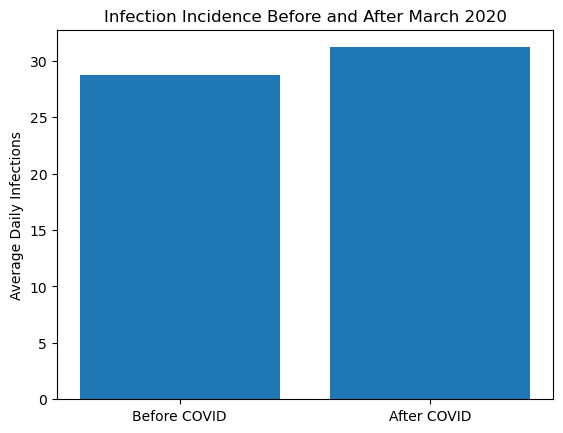

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_f["fecha"] = pd.to_datetime(df_f["fecha"])

# Group infections by date and calculate the total number of infections for each date
conteo_infecciones = df_f.groupby("fecha").size()
rango_fechas = pd.date_range(start=conteo_infecciones.index.min(), end=conteo_infecciones.index.max(), freq='D')

# Create a DataFrame with the date range as index and the count of infections
datos_infecciones = pd.DataFrame({"fecha": conteo_infecciones}, index=rango_fechas)
datos_infecciones.fillna(0, inplace=True)
datos_infecciones.rename(columns={"fecha": 'infecciones'}, inplace=True)

# Split data into before and after March 2020
datos_antes_covid = datos_infecciones.loc[datos_infecciones.index < '2020-03-01']
datos_despues_covid = datos_infecciones.loc[datos_infecciones.index >= '2020-03-01']

# Calculate the average daily incidence of infections before and after March 2020
incidencia_antes_covid = datos_antes_covid['infecciones'].sum() / len(datos_antes_covid)
incidencia_despues_covid = datos_despues_covid['infecciones'].sum() / len(datos_despues_covid)

# Plotting
plt.bar(['Before COVID', 'After COVID'], [incidencia_antes_covid, incidencia_despues_covid])
plt.ylabel('Average Daily Infections')
plt.title('Infection Incidence Before and After March 2020')
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap



In [ ]:
ruta_archivo_shp = 'Bases\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'
dataframe_shp = gpd.read_file(ruta_archivo_shp)
# dataframe_shp=dataframe_shp.loc[dataframe_shp["codpcia"]!="94"]


In [ ]:
dataframe_shp
import geopandas as gpd

# Suponiendo que ya cargaste tu GeoDataFrame como `gdf`
# Primero, convertí a coordenadas proyectadas
dataframe_shp = dataframe_shp.to_crs(epsg=5347)  # o usá 3857 si no te interesa alta precisión

# Ahora calculá el área en m² y pasalo a km²
dataframe_shp["area_km2"] = dataframe_shp["geometry"].area / 1e6

# Calculá la densidad
dataframe_shp["densidad"] = dataframe_shp["personas"].astype(int) / dataframe_shp["area_km2"]

dataframe_shp.head()



,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry,area_km2,densidad
0,02001,02,Comuna 1,Ciudad Autónoma de Buenos Aires,107789,98097,205886,84468,130771,78360,"POLYGON ((5649103.995 6172812.458, 5649849.710...",18.205729,11308.857477
1,02002,02,Comuna 2,Ciudad Autónoma de Buenos Aires,89890,68042,157932,73156,107967,70869,"POLYGON ((5646748.594 6173774.225, 5646819.854...",6.306811,25041.497834
2,02003,02,Comuna 3,Ciudad Autónoma de Buenos Aires,101936,85601,187537,80489,101161,75605,"POLYGON ((5647355.095 6170403.970, 5647368.891...",6.389475,29350.924095
3,02004,02,Comuna 4,Ciudad Autónoma de Buenos Aires,115079,103166,218245,76455,82926,69680,"POLYGON ((5650689.333 6168324.109, 5650710.586...",22.151278,9852.479000
4,06091,06,Berazategui,Buenos Aires,165636,158608,324244,93164,96025,86248,"POLYGON ((5681516.353 6149854.781, 5675285.557...",220.276885,1471.983772


In [ ]:
dataframe_shp.loc[dataframe_shp["provincia"].str.contains("Tierra")]

dataframe_shp=dataframe_shp.loc[(~dataframe_shp["departamen"].str.contains("Islas del Atlántico Sur"))&(~dataframe_shp["departamen"].str.contains("Antártida"))]

dataframe_shp

,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry,area_km2,densidad,Código
0,02001,02,Comuna 1,Ciudad Autónoma de Buenos Aires,107789,98097,205886,84468,130771,78360,"POLYGON ((5649103.995 6172812.458, 5649849.710...",18.205729,11308.857477,2.0
1,02002,02,Comuna 2,Ciudad Autónoma de Buenos Aires,89890,68042,157932,73156,107967,70869,"POLYGON ((5646748.594 6173774.225, 5646819.854...",6.306811,25041.497834,2.0
2,02003,02,Comuna 3,Ciudad Autónoma de Buenos Aires,101936,85601,187537,80489,101161,75605,"POLYGON ((5647355.095 6170403.970, 5647368.891...",6.389475,29350.924095,2.0
3,02004,02,Comuna 4,Ciudad Autónoma de Buenos Aires,115079,103166,218245,76455,82926,69680,"POLYGON ((5650689.333 6168324.109, 5650710.586...",22.151278,9852.479000,2.0
4,06091,06,Berazategui,Buenos Aires,165636,158608,324244,93164,96025,86248,"POLYGON ((5681516.353 6149854.781, 5675285.557...",220.276885,1471.983772,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,90105,90,Tafí Viejo,Tucumán,62151,59487,121638,29772,31491,26614,"POLYGON ((4929706.906 7055384.842, 4930096.801...",1147.389622,106.012812,90.0
522,90112,90,Trancas,Tucumán,8478,8893,17371,4441,6889,4204,"POLYGON ((4944833.295 7103225.394, 4944929.473...",3090.241810,5.621243,90.0
523,90119,90,Yerba Buena,Tucumán,38500,36576,75076,18560,19691,17171,"POLYGON ((4977045.959 7027323.936, 4976861.904...",149.165383,503.307126,90.0
524,94007,94,Río Grande,Tierra del Fuego,34095,35947,70042,21410,23298,19790,"POLYGON ((4943842.488 3920559.784, 4941309.360...",11835.776472,5.917820,94.0


In [ ]:
df_sida=pd.read_excel("Bases\\indec\\030304_2022.xlsx",header=5)
df_sida=df_sida.rename(columns={"Unnamed: 0":"Jurisdicción"})
df_sida=df_sida.loc[~df_sida[2013].isnull()][df_sida.columns[:11]][1:]
df_sida.replace(" -", 0, inplace=True)
df_sida.iloc[:, 1:]=df_sida.iloc[:, 1:].astype(float)
df_sida["Muertes Promedio Sida"] = df_sida.iloc[:, 1:].mean(axis=1, skipna=True)
df_sida=df_sida[["Jurisdicción","Muertes Promedio Sida"]]
# df_sida=df_sida.loc[~df_sida["Jurisdicción"].str.contains("Tierra del Fuego")]
df_sida.head()

,Jurisdicción,Muertes Promedio Sida
2,Ciudad Autónoma de Buenos Aires,3.99
3,Buenos Aires,3.73
4,Catamarca,1.60
5,Chaco,1.64
6,Chubut,3.35


In [ ]:


df_cobertura=pd.read_excel("Bases\\indec\\c2022_tp_salud_c1.xlsx",sheet_name="Cobertura de salud N°1")

df_cobertura.loc[df_cobertura["Jurisdicción"].str.contains("Tierra del",na=False),"Código"]=94.0
df_cobertura.loc[df_cobertura["Jurisdicción"].str.contains("Tucumán",na=False),"Código"]=90.0
df_cobertura=df_cobertura.loc[~df_cobertura["Código"].isnull()]
df_cobertura["Sin Cobertura %"]=df_cobertura["No tiene obra social, prepaga ni plan estatal"]/df_cobertura["Población total (1)"]

df_cobertura2=df_cobertura[["Código","Jurisdicción","Sin Cobertura %"]]
dataframe_shp["Código"]=dataframe_shp["codpcia"].astype(float)
gdf_provincias = dataframe_shp.dissolve(by="codpcia", as_index=False)
gdf_provincias.head()

,codpcia,geometry,link,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,area_km2,densidad,Código
0,02,"POLYGON ((5644371.185 6163520.106, 5644352.753...",02001,Comuna 1,Ciudad Autónoma de Buenos Aires,107789,98097,205886,84468,130771,78360,18.205729,11308.857477,2.0
1,06,"MULTIPOLYGON (((5301314.849 5535707.061, 53013...",06091,Berazategui,Buenos Aires,165636,158608,324244,93164,96025,86248,220.276885,1471.983772,6.0
2,10,"POLYGON ((4958961.290 6686669.075, 4958960.104...",10007,Ambato,Catamarca,2142,2321,4463,1294,3093,1250,2006.218005,2.224584,10.0
3,14,"POLYGON ((5025348.877 6239637.613, 5025347.385...",14063,Marcos Juárez,Córdoba,53233,50972,104205,35476,40874,34404,9285.693395,11.222102,14.0
4,18,"POLYGON ((5635068.751 6662604.134, 5634745.787...",18070,Goya,Corrientes,46645,43314,89959,24344,25802,22914,4762.594441,18.888654,18.0


In [ ]:
gdf_provincias["Código"]=gdf_provincias["Código"].astype(str)
df_cobertura2["Código"]=df_cobertura2["Código"].astype(str)

In [ ]:


df_arg_cobertura=pd.merge(df_cobertura2,gdf_provincias[["Código","geometry","densidad"]],on=["Código"],how="left")
# df_arg_cobertura=df_arg_cobertura.loc[~df_arg_cobertura["Jurisdicción"].str.contains("Tierra del Fuego")]


df_arg_cobertura=pd.merge(df_arg_cobertura,df_sida,on="Jurisdicción",how="left")

df_arg_cobertura.head()

,Código,Jurisdicción,Sin Cobertura %,geometry,densidad,Muertes Promedio Sida
0,2.0,Ciudad Autónoma de Buenos Aires,0.163116,"POLYGON ((5644371.185 6163520.106, 5644352.753...",11308.857477,3.99
1,6.0,Buenos Aires,0.351050,"MULTIPOLYGON (((5301314.849 5535707.061, 53013...",1471.983772,3.73
2,10.0,Catamarca,0.406700,"POLYGON ((4958961.290 6686669.075, 4958960.104...",2.224584,1.60
3,22.0,Chaco,0.522185,"POLYGON ((5393592.919 6902986.405, 5393302.415...",14.861738,1.64
4,26.0,Chubut,0.278363,"MULTIPOLYGON (((4718799.149 4855763.641, 47107...",6.469800,3.35


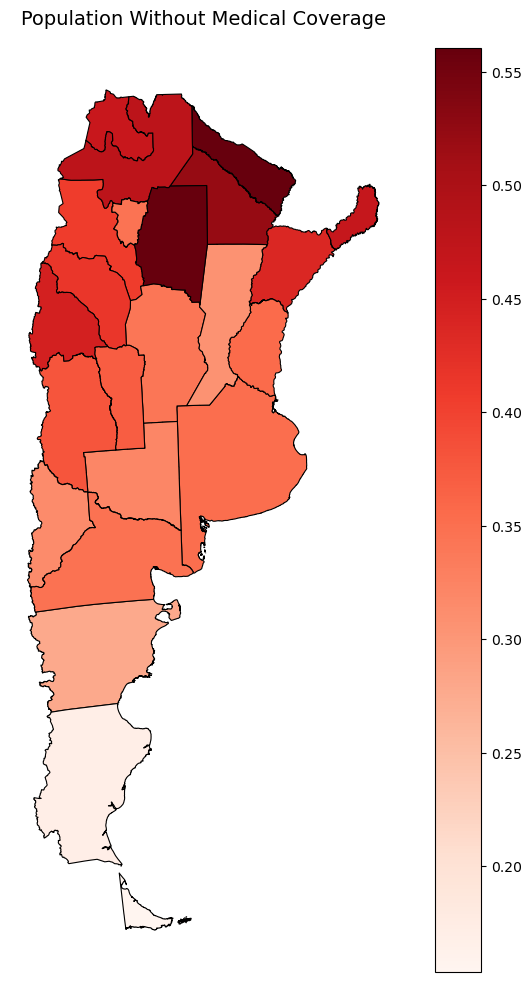

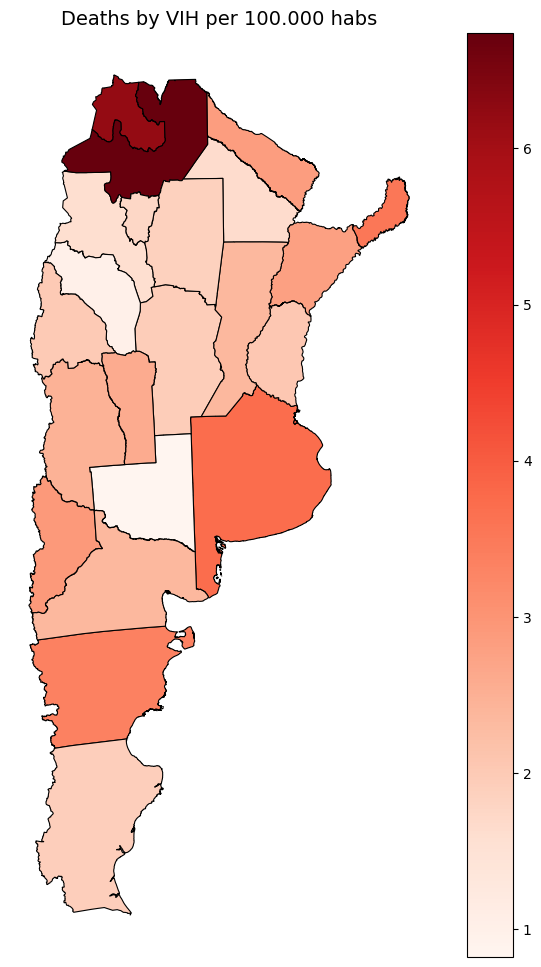

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def mapear_indicadores(df_arg_cobertura, indicador, j):
    df_arg_cobertura2 = gpd.GeoDataFrame(df_arg_cobertura, geometry="geometry", crs="EPSG:4326")

    # Crear el mapa estático
    fig, ax = plt.subplots(figsize=(10, 12))
    df_arg_cobertura2.plot(column=indicador, cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

    # Configurar título y ocultar ejes
    lista_titles = ["Population Without Medical Coverage", "Deaths by VIH per 100.000 habs", "Population Density"]
    ax.set_title(lista_titles[j], fontsize=14)

    # if "Jurisdicción" in df_arg_cobertura2.columns:
    #     # Si está por provincia, etiquetá normalmente
    #     for idx, row in df_arg_cobertura2.iterrows():
    #         centroid = row["geometry"].centroid
    #         text = row["Jurisdicción"].replace("Ciudad Autónoma de Buenos Aires","CABA")
    #         ax.annotate(text, xy=(centroid.x, centroid.y),
    #                     ha='center', va='center',
    #                     fontsize=11, color="black", weight="bold",
    #                     bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    # else:
    #     # Si está por departamento, agrupá por provincia
    #     prov_labels = df_arg_cobertura2.dissolve(by="provincia", as_index=False)[["provincia", "geometry"]]

    #     for idx, row in prov_labels.iterrows():
    #         centroid = row["geometry"].centroid
    #         text = row["provincia"]
    #         ax.annotate(text, xy=(centroid.x, centroid.y),
    #                     ha='center', va='center',
    #                     fontsize=8, color="black", weight="bold",
    #                     bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    # Ocultar ejes
    ax.set_axis_off()

    # Mostrar el mapa
    plt.savefig('Documentacion\\figures\\'+lista_titles[j]+'.png', dpi=300)
    plt.show()
    plt.close("all")
j=0

for i in ["Sin Cobertura %","Muertes Promedio Sida"]:
        
        mapear_indicadores(df_arg_cobertura,i,j)
        j=j+1

# mapear_indicadores(dataframe_shp,"densidad",2)


In [ ]:
dataframe_shp

,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry,area_km2,densidad,Código
0,02001,02,Comuna 1,Ciudad Autónoma de Buenos Aires,107789,98097,205886,84468,130771,78360,"POLYGON ((5649103.995 6172812.458, 5649849.710...",18.205729,11308.857477,2.0
1,02002,02,Comuna 2,Ciudad Autónoma de Buenos Aires,89890,68042,157932,73156,107967,70869,"POLYGON ((5646748.594 6173774.225, 5646819.854...",6.306811,25041.497834,2.0
2,02003,02,Comuna 3,Ciudad Autónoma de Buenos Aires,101936,85601,187537,80489,101161,75605,"POLYGON ((5647355.095 6170403.970, 5647368.891...",6.389475,29350.924095,2.0
3,02004,02,Comuna 4,Ciudad Autónoma de Buenos Aires,115079,103166,218245,76455,82926,69680,"POLYGON ((5650689.333 6168324.109, 5650710.586...",22.151278,9852.479000,2.0
4,06091,06,Berazategui,Buenos Aires,165636,158608,324244,93164,96025,86248,"POLYGON ((5681516.353 6149854.781, 5675285.557...",220.276885,1471.983772,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,90105,90,Tafí Viejo,Tucumán,62151,59487,121638,29772,31491,26614,"POLYGON ((4929706.906 7055384.842, 4930096.801...",1147.389622,106.012812,90.0
522,90112,90,Trancas,Tucumán,8478,8893,17371,4441,6889,4204,"POLYGON ((4944833.295 7103225.394, 4944929.473...",3090.241810,5.621243,90.0
523,90119,90,Yerba Buena,Tucumán,38500,36576,75076,18560,19691,17171,"POLYGON ((4977045.959 7027323.936, 4976861.904...",149.165383,503.307126,90.0
524,94007,94,Río Grande,Tierra del Fuego,34095,35947,70042,21410,23298,19790,"POLYGON ((4943842.488 3920559.784, 4941309.360...",11835.776472,5.917820,94.0


In [ ]:
df_arg_cobertura

,Código,Jurisdicción,Sin Cobertura %,geometry,densidad,Muertes Promedio Sida
0,2.0,Ciudad Autónoma de Buenos Aires,0.163116,"POLYGON ((5644371.185 6163520.106, 5644352.753...",11308.857477,3.99
1,6.0,Buenos Aires,0.351050,"MULTIPOLYGON (((5301314.849 5535707.061, 53013...",1471.983772,3.73
2,10.0,Catamarca,0.406700,"POLYGON ((4958961.290 6686669.075, 4958960.104...",2.224584,1.60
3,22.0,Chaco,0.522185,"POLYGON ((5393592.919 6902986.405, 5393302.415...",14.861738,1.64
4,26.0,Chubut,0.278363,"MULTIPOLYGON (((4718799.149 4855763.641, 47107...",6.469800,3.35
5,14.0,Córdoba,0.341695,"POLYGON ((5025348.877 6239637.613, 5025347.385...",11.222102,1.93
6,18.0,Corrientes,0.437639,"POLYGON ((5635068.751 6662604.134, 5634745.787...",18.888654,2.79
7,30.0,Entre Ríos,0.356380,"POLYGON ((5643028.679 6292802.973, 5642960.058...",17.256249,2.06
8,34.0,Formosa,0.558824,"POLYGON ((5677933.673 7081304.525, 5677649.425...",1.006857,2.84
9,38.0,Jujuy,0.462396,"POLYGON ((4920935.615 7309983.571, 4920885.139...",1.699012,6.19
